<a href="https://colab.research.google.com/github/truongvanhuy2000/DeepLearningProject/blob/main/Copy_of_Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.2


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import plotly.express as px

from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential

from tensorflow.keras.optimizers import Adam,SGD,RMSprop

# Copy Data From Drive


In [4]:
!cp '/content/drive/MyDrive/Deep-learning/archive.zip' '/content/' 

In [6]:
import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Displaying Images

In [7]:
picture_size = 48
folder_path = "/content/images/"

In [8]:
import fnmatch
train_count = []
valid_count = []
dỉr_label  = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', "surprise"]
for i in range(len(dỉr_label)):
  train_count.append(len(fnmatch.filter(os.listdir(folder_path + 'train/' + dỉr_label[i]), '*.*')))
  valid_count.append(len(fnmatch.filter(os.listdir(folder_path + 'validation/' + dỉr_label[i]), '*.*')))
print('Train Count:', train_count)
print('Valid count:', valid_count)

Train Count: [3993, 436, 4103, 7164, 4982, 4938, 3205]
Valid count: [960, 111, 1018, 1825, 1216, 1139, 797]


In [ ]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [9]:
def plotDistribution(count):
  CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
  fig = px.bar(x = CLASS_LABELS,
              y = [count[i] for i in range(7)] , 
              color = np.unique(count),
              color_continuous_scale="Emrld") 
  fig.update_xaxes(title="Emotions")
  fig.update_yaxes(title = "Number of Images")
  fig.update_layout(showlegend = True,
      title = {
          'text': 'Train Data Distribution ',
          'y':0.95,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'})
  fig.show()

In [10]:
plotDistribution(train_count)
plotDistribution(valid_count)

# Making Training and Validation Data

In [11]:
batch_size  = 64 #128 example per interation

datagen_train  = ImageDataGenerator(rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

        
datagen_val = ImageDataGenerator(rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')


train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [ ]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3), kernel_initializer='HeNormal' ,padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.35))

#2nd CNN layer
model.add(Conv2D(64,(3,3), kernel_initializer='HeNormal', padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))

#3rd CNN layer
model.add(Conv2D(128,(3,3), kernel_initializer='HeNormal',padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout (0.5))

#4th CNN layer
model.add(Conv2D(128,(3,3), kernel_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#5th CNN layer
model.add(Conv2D(256,(3,3), kernel_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#6th CNN layer
model.add(Conv2D(256,(3,3), kernel_initializer='HeNormal', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Fully connected layer 2nd layer

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(no_of_classes, activation='softmax'))



In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
opt = Adam(lr = 0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 48, 48, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Fitting the Model with Training and Validation Data

In [ ]:
epochs = 100
history = model.fit(train_set,steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = val_set,
                                validation_steps = val_set.n//val_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/100
484/484 [==============================] - 36s 72ms/step - loss: 1.9153 - accuracy: 0.2180 - val_loss: 1.8598 - val_accuracy: 0.2341 - lr: 5.0000e-04
Epoch 2/100
484/484 [==============================] - 34s 70ms/step - loss: 1.8377 - accuracy: 0.2345 - val_loss: 1.8363 - val_accuracy: 0.2513 - lr: 5.0000e-04
Epoch 3/100
484/484 [==============================] - 33s 68ms/step - loss: 1.8271 - accuracy: 0.2366 - val_loss: 1.8314 - val_accuracy: 0.2082 - lr: 5.0000e-04
Epoch 4/100
484/484 [==============================] - 33s 68ms/step - loss: 1.8232 - accuracy: 0.2418 - val_loss: 1.8370 - val_accuracy: 0.2550 - lr: 5.0000e-04
Epoch 5/100
484/484 [==============================] - 35s 72ms/step - loss: 1.8129 - accuracy: 0.2466 - val_loss: 1.8706 - val_accuracy: 0.2464 - lr: 5.0000e-04
Epoch 6/100
484/484 [==============================] - 38s 79ms/step - loss: 1.7972 - accuracy: 0.2571 - val_loss: 1.7524 - val_accuracy: 0.2881 - lr: 5.0000e-04
Epoch 7/100
484/484 [=======

# Plotting Accuracy & Loss

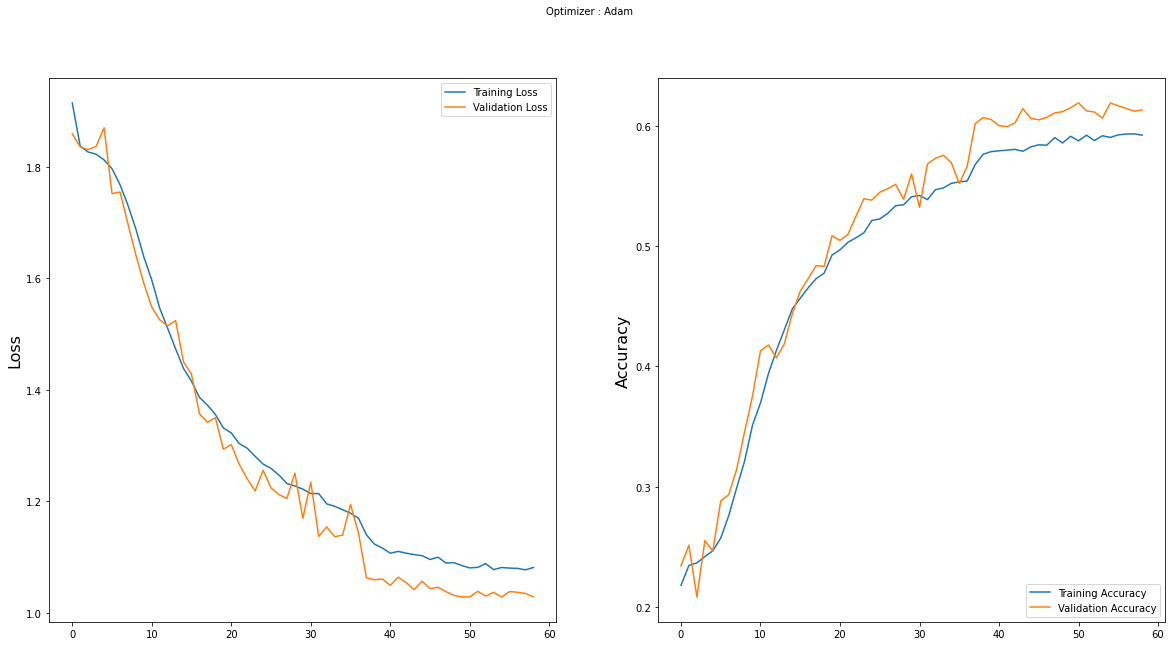

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Saving Model and Testing

In [ ]:
model.save('/content/drive/MyDrive/Deep-learning/my_model_final_final_final.h5')

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')
test_set = datagen_test.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=10,
                                              class_mode='categorical',
                                              shuffle=False)

Found 414 images belonging to 7 classes.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Deep-learning/my_model_final.h5')

In [ ]:
y = model.evaluate(test_set)

42/42 [==============================] - 0s 10ms/step - loss: 0.2679 - accuracy: 0.9179
